In [ ]:
!python --version

Python 3.10.12


In [1]:
# ----------------------------------------------------------------------
# Importamos las librerías principales
# ----------------------------------------------------------------------

import numpy as np
from numpy import linalg as LA # no lo uso de momento

# QP solvers
!pip install qpsolvers
from qpsolvers import solve_qp
import warnings # para ignorar alertas de algunos solvers

# Para graficar
import matplotlib.pyplot as plt
from seaborn import color_palette

# Para animar y visualizar animaciones
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ----------------------------------------------------------------------
# Constantes que se van a utilizar a lo largo de todo el notebook
# ----------------------------------------------------------------------

# Matriz rotación -90º
E = np.array([[0, 1],[-1, 0]])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 21.8 MB/s eta 0:00:00


In [2]:
# ----------------------------------------------------------------------
# Toolbox
# ----------------------------------------------------------------------

from matplotlib.path import Path
import matplotlib.patches as patches

# Paletas de colores suaves (https://g.co/kgs/4A3q4T)
cake_b = "#d9daff"
cake_r = "#ffdbd9"
cake_y = "#fffbd9"
cake_g = "#dcffd9"

"""
Unicycle_patch (Héctor García de Marina)
"""
def unicycle_patch(XY, yaw, color, size=1, lw=0.5):
    # XY es una lista [X, Y]
    Rot = np.array([[np.cos(yaw), np.sin(yaw)],[-np.sin(yaw), np.cos(yaw)]])

    apex = 45*np.pi/180 # 30 degrees apex angle
    b = np.sqrt(1) / np.sin(apex)
    a = b*np.sin(apex/2)
    h = b*np.cos(apex/2)

    z1 = size*np.array([a/2, -h*0.3])
    z2 = size*np.array([-a/2, -h*0.3])
    z3 = size*np.array([0, h*0.6])

    z1 = Rot.dot(z1)
    z2 = Rot.dot(z2)
    z3 = Rot.dot(z3)

    verts = [(XY[0]+z1[1], XY[1]+z1[0]), \
             (XY[0]+z2[1], XY[1]+z2[0]), \
             (XY[0]+z3[1], XY[1]+z3[0]), \
             (0, 0)]

    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    path = Path(verts, codes)

    return patches.PathPatch(path, fc=color, lw=lw)

"""
absmaxND
"""
def absmaxND(a):
  amax = np.max(a)
  amin = np.min(a)
  return np.where(-amin > amax, amin, amax)

"""
Función para dar formato a los plots de datos
"""
def fmt_data_axis(ax, ylabel = "", xlabel = "", title = "",
                  xlim = None, ylim = None, d=2):
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)

  if xlim is not None:
    ax.set_xlim(xlim)
  if ylim is not None:
    ax.set_ylim(ylim)

  ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.{}f'.format(d)))
  ax.yaxis.tick_right()
  ax.grid(True)

"""
Función para calcular los puntos corte P1 y P2, con respectro una circunferencia
con centro en "c" y radio "r", que generan las dos rectas tangentes que pasan
por P1.
"""
def cone_params(c, r, p0):
  cx, cy = c
  x0, y0 = np.array(p0) - np.array(c)

  d0 = np.sqrt(x0**2 + y0**2)
  if d0 > r:
    p1 = r**2/d0**2 * np.array([x0,y0]) + r/d0**2 * np.sqrt(d0**2 - r**2) * np.array([-y0,x0]) + np.array([cx,cy])
    p2 = r**2/d0**2 * np.array([x0,y0]) - r/d0**2 * np.sqrt(d0**2 - r**2) * np.array([-y0,x0]) + np.array([cx,cy])
    return p1, p2
  else:
    return None, None

# GVF ellipse

## **class:** gvf_ellipse

In [3]:
# ----------------------------------------------------------------------------
# Todas los cálculos están vectorizados para poder realizarlos sobre N agentes
#
# -> p es una matriz     N x 2
# -> XYoff es un vector  1 x 2
# -> R es una matriz rotación (su inversa equivale a su transpuesta)
# ----------------
class gvf_ellipse:
  def __init__(self, XYoff, alpha, a, b):
    # Parámetros de la elipse
    self.XYoff = XYoff
    self.alpha = alpha
    self.a, self.b = a, b

    self.cosa, self.sina = np.cos(alpha), np.sin(alpha)
    self.R = np.array([[self.cosa, self.sina], [-self.sina, self.cosa]])

    # Variables para dibujar la trayectoria y el campo
    self.traj_points = self.param_points()
    self.mapgrad_pos = [[]]
    self.mapgrad_vec = [[]]

    # Phi hessian
    self.hess = np.zeros((2,2))
    self.hess[0,0] = 2 * (self.cosa**2 / self.a**2 + self.sina**2 / self.b**2)
    self.hess[0,1] = 2 * self.sina * self.cosa * (1 / self.b**2 - 1 / self.a**2)
    self.hess[1,0] = self.hess[0,0]
    self.hess[1,1] = 2 * (self.sina**2 / self.a**2 + self.cosa**2 / self.b**2)

  # Puntos para pintar la trayectoria
  def param_points(self, pts = 100):
    t = np.linspace(0, 2*np.pi, pts)
    x = self.XYoff[0] + self.a * np.cos(-self.alpha) * np.cos(t) \
                      - self.b * np.sin(-self.alpha) * np.sin(t)
    y = self.XYoff[1] + self.a * np.sin(-self.alpha) * np.cos(t) \
                      + self.b * np.cos(-self.alpha) * np.sin(t)
    return (x, y)

  # Phi
  def phi(self, p):
    w = self.XYoff * np.ones([p.shape[0],1])
    pel = (p - w) @ self.R
    return (pel[:,0]/self.a)**2 + (pel[:,1]/self.b)**2 - 1

  # Phi gradiant
  def grad_phi(self, p):
    w = self.XYoff * np.ones([p.shape[0],1])
    pel = (p - w) @ self.R
    return 2 * pel / [self.a**2, self.b**2] @ self.R.T

  # Generamos el campo de vectores a dibujar
  # pn es una matriz N x 2
  def vector_field(self, XYoff, area, s, ke, kb = 0, kr = 1, pn = None, n_focus = None, pts = 30):
    x_lin = np.linspace(XYoff[0] - 0.5*np.sqrt(area), \
                        XYoff[0] + 0.5*np.sqrt(area), pts)
    y_lin = np.linspace(XYoff[1] - 0.5*np.sqrt(area), \
                        XYoff[1] + 0.5*np.sqrt(area), pts)
    mapgrad_X, mapgrad_Y = np.meshgrid(x_lin, y_lin)
    mapgrad_X = np.reshape(mapgrad_X, -1)
    mapgrad_Y = np.reshape(mapgrad_Y, -1)
    self.mapgrad_pos = np.array([mapgrad_X, mapgrad_Y]).T

    w = self.XYoff * np.ones([self.mapgrad_pos.shape[0],1])
    pel = (self.mapgrad_pos - w) @ self.R

    n = self.grad_phi(self.mapgrad_pos)
    t = s*n @ E.T

    e = self.phi(self.mapgrad_pos)[:,None]

    self.mapgrad_vec = t - ke*e*n

    if kb != 0:
      # Añadimos una interacción de repulsión electroestática basa en iones
      for i in range(pn.shape[0]):
        if i!=n_focus:
          r_vec  = self.mapgrad_pos - pn[i,:]
          r_norm = np.sqrt(r_vec[:,0]**2 + r_vec[:,1]**2)[:,None]
          self.mapgrad_vec += kb / r_norm**(1 + kr) * r_vec

    norm = np.sqrt(self.mapgrad_vec[:,0]**2 + self.mapgrad_vec[:,1]**2)[:,None]
    self.mapgrad_vec = self.mapgrad_vec / norm

  # Se manda la información necesaria para el controlador
  def info(self, p):
    return self.phi(p), self.grad_phi(p), self.hess

# ----------------------------------------------------------------------------

# ----------------------------------------------------------------------------
# Función para dibujar el campo vectorial y la trayectoria
def draw(gvf_ell, fig=None, ax=None, xlim=None, ylim=None, draw_field=True):
  if fig == None:
    fig = plt.figure(dpi=100)
    ax = fig.subplots()
  elif ax == None:
    ax = fig.subplots()

  ax.plot(gvf_ell.XYoff[0], gvf_ell.XYoff[1], "+k", zorder=0)
  ax.plot(gvf_ell.traj_points[0], gvf_ell.traj_points[1], "k--", zorder=0)

  if xlim:
    ax.set_xlim(xlim)
  if ylim:
    ax.set_ylim(ylim)

  if draw_field:
    field = ax.quiver(gvf_ell.mapgrad_pos[:,0], gvf_ell.mapgrad_pos[:,1], \
                      gvf_ell.mapgrad_vec[:,0], gvf_ell.mapgrad_vec[:,1], \
                      alpha=0.5)
    return fig, ax, field

# ----------------------------------------------------------------------------

## **gvf_ellipse**: Visualización del campo vectorial

In [4]:
# Some plotting
%matplotlib inline

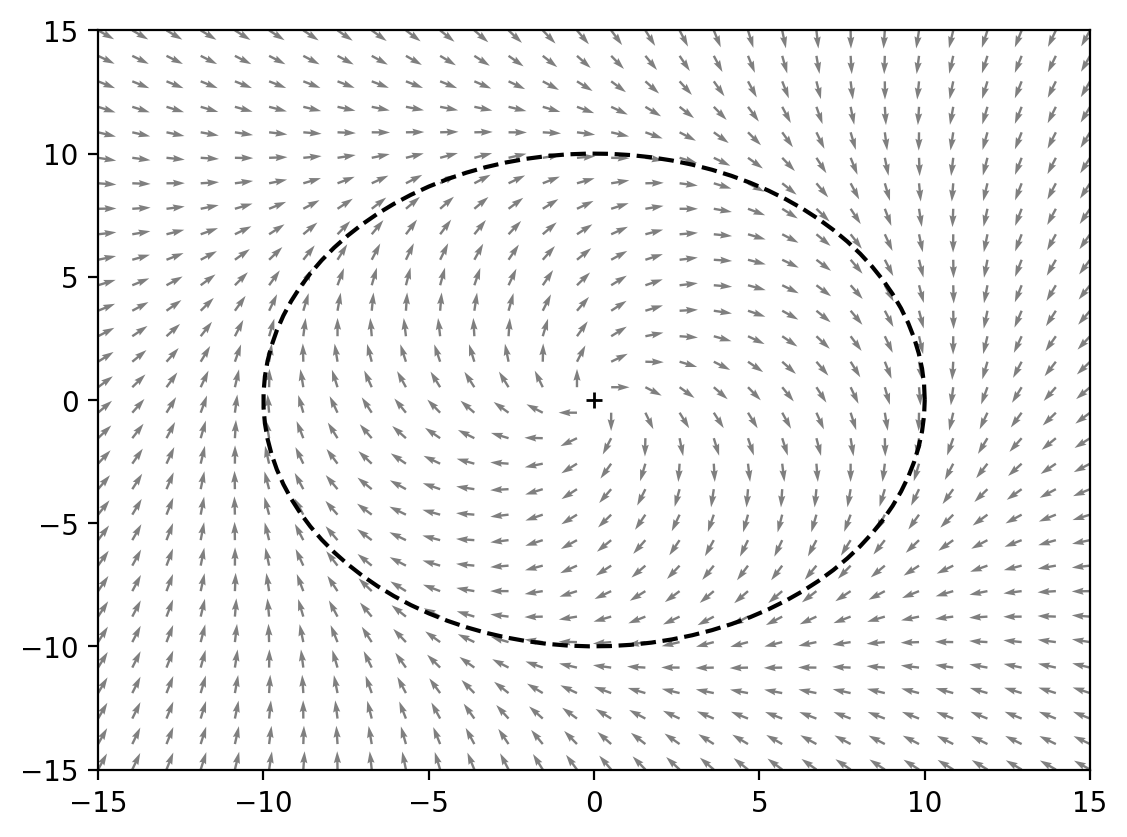

In [5]:
# Parámetros de la trayectoria
XYoff = [0, 0]
a, b = 10, 10
alpha = 0

gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

XYoff_vfield = XYoff
area = 30**2
s = 1
ke = 1

# Generamos el campo vectorial sin repulsión
fig = plt.figure(dpi=200)
ax = fig.subplots()

gvf_traj.vector_field(XYoff_vfield, area, s, ke)
draw(gvf_traj, fig, ax, (-15,15), (-15,15))
plt.show()


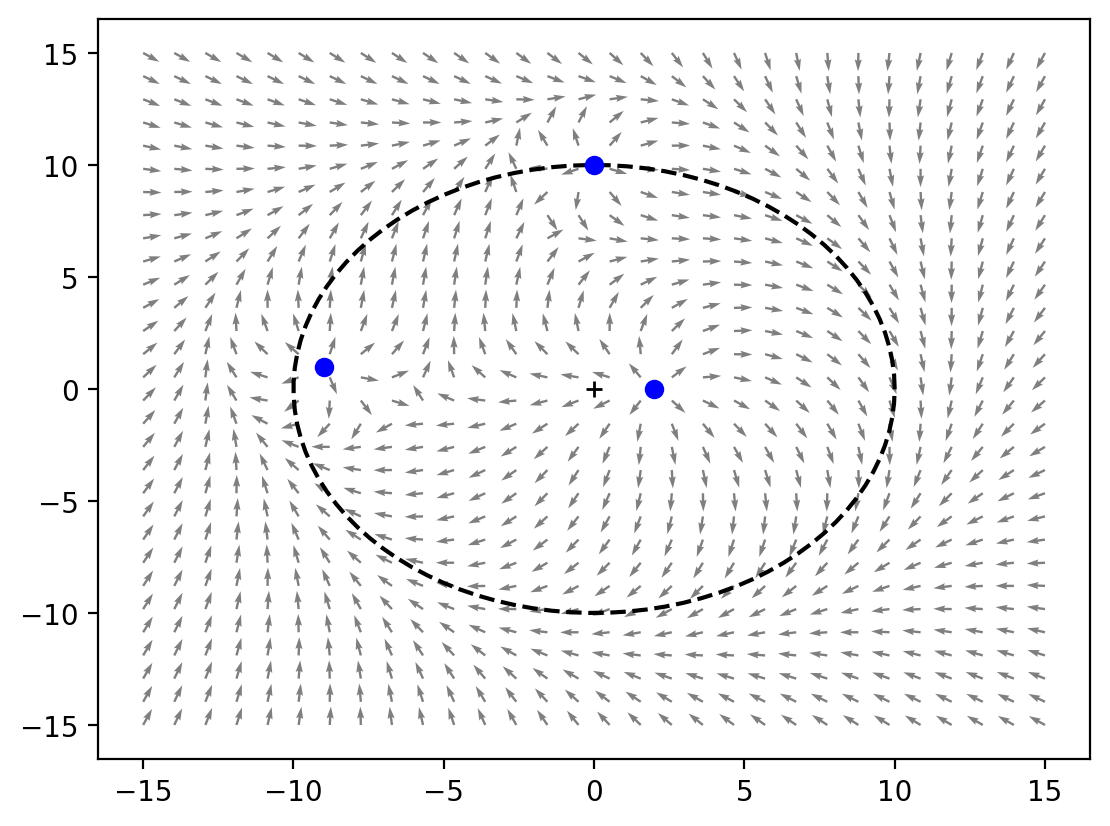

In [6]:
fig = plt.figure(dpi=200)
ax = fig.subplots()

# Generamos el campo vectorial con repulsiones
kb = 1
kr = 1.5
pn = np.array([[-9, 1], [0,10], [2,0]])

gvf_traj.vector_field(XYoff_vfield, area, s, ke, kb, kr, pn)

draw(gvf_traj, fig, ax)
for pi in pn:
  plt.plot(pi[0], pi[1],"ob")
plt.show()


# Simulaciones

## **class**: gvf_simulation

In [33]:
# ----------------------------------------------------------------------
# GVF simulation class (gvf_control + cbf colision avoid controller)
# ----------------------------------------------------------------------

# -> x0:    [t0, p0, v0, phi0]

# - P es una matriz  N x 2
# - v es un vector   N x 1 (norma de la velocidad)
# - phi es un vector N x 1
# - w es un vector   N x 1

class gvf_simulation:
    def __init__(self, gvf_traj, kinematics, n_agents, x0, dt = 0.01, cbf_sw = False):
      self.traj = gvf_traj         # Trayectoria a seguir por los agentes
      self.kinematics = kinematics # Dinámica de los robots
      self.N = n_agents            # Número de agentes simulados
      self.t0 = x0[0]              # Tiempo inicial de la simulación (s)
      self.t  = x0[0]              # Tiempo actual de la simulación (s)
      self.dt = dt                 # Pasos temporales en la simulación (s)

      # Vectores de estados (fila -> agente)
      self.p0 = x0[1]    # Matriz N x 2 de posiciones iniciales
      self.pf = x0[1]
      self.v0 = x0[2]
      self.vf = x0[2]
      self.phi0 = x0[3]
      self.phif = x0[3]
      self.w = np.zeros([n_agents])
      self.e = np.zeros([n_agents])

      # Parámetros del robot
      self.L = 0.8                      # m
      self.delta_max = 15 * np.pi / 180 # rad

      # Parámetros de los controladores
      self.s  = 1
      self.ke = 1
      self.kn = 1

      self.r = 0.6
      self.gamma = 1

      # Switch para seleccionar el tipo de algoritmo para evitar colisiones
      self.cbf_sw = cbf_sw

      # Declaramos variables a monitorizar ---------------------
      #self.dot_rel = np.zeros([n_agents, n_agents])
      self.h = np.zeros([n_agents, n_agents])
      self.h_dot = np.zeros([n_agents, n_agents])
      self.kappa = np.zeros([n_agents, n_agents])
      self.psi = np.zeros([n_agents, n_agents])

      self.omega_safe = np.zeros([n_agents])
      # --------------------------------------------------------

    def set_params(self, s = None, ke = None, kn = None, r = None, gamma = None):
      params = [s, ke, kn, r, gamma]
      params_def = self.s, self.ke, self.kn, self.r, self.gamma

      for i in range(len(params)):
        if params[i] == None:
          params[i] == params_def[i]

      self.s, self.ke, self.kn, self.r, self.gamma = params

    def omega_clip(self, omega):
      max_w = self.vf/self.L * np.tan(self.delta_max) # N x 1
      w_clipped = omega
      for i in range(self.N):
        w_clipped[i] = np.clip(omega[i], -max_w[i], max_w[i])
      return w_clipped

    def gvf_control(self):
      # Phi (error)  N x 1
      self.e = self.traj.phi(self.pf)
      # Phi gradient N x 2
      n = self.traj.grad_phi(self.pf)
      # Phi tangent  N x 2
      t = self.s*n @ E.T
      # Phi hessian  2 x 2
      H = self.traj.hess

      # Compute the desired angular velocity to aling with the vector field
      omega = np.zeros(self.N)
      for i in range(self.N):
        ei = self.e[i]
        ni = n[i,:][:,None]
        ti = t[i,:][:,None]

        pd_dot = ti - self.ke*ei*ni

        norm_pd_dot = np.sqrt(pd_dot[0]**2 + pd_dot[1]**2)
        md = pd_dot / norm_pd_dot

        Apd_dot_dot = - self.ke * ni.T @ pd_dot * ni
        Bpd_dot_dot = (E.T - self.ke * ei) @ H @ pd_dot
        pd_dot_dot = Bpd_dot_dot + Apd_dot_dot

        md_dot_const = md.T @ E.T @ pd_dot_dot / norm_pd_dot
        md_dot = E.T @ md * md_dot_const

        omega_d = md_dot.T @ E.T @ md
        mr = np.array([np.cos(self.phif[i]), np.sin(self.phif[i])])

        omega[i] = omega_d + self.kn * mr @ E.T @ md

      # Clip the response of the controller by the mechanical saturation value
      omega = self.omega_clip(omega)

      return -omega

    def cbf_colAvoid(self):
      omega = np.copy(self.w)

      # Inicializamos las variables de telemetría
      self.h = np.zeros([n_agents, n_agents])
      self.h_dot = np.zeros([n_agents, n_agents])
      self.kappa = np.zeros([n_agents, n_agents])
      self.psi = np.zeros([n_agents, n_agents])
      self.omega_safe = np.zeros([n_agents])

      # Mientras se satisfacen las siguientes condiciones
      for i in range(self.N):
        omega_ref = self.w[i]
        P = self.pf
        V = self.vf * np.array([np.cos(self.phif), np.sin(self.phif)]).T

        psi_lgh_k = []
        for k in [k for k in range(self.N) if k!=i]:
          v = self.vf[i]
          phi = self.phif[i]

          prel = P[i,:] - P[k,:]
          prel_sqr = np.dot(prel, prel)
          prel_norm = np.sqrt(prel_sqr)

          if prel_sqr > self.r**2: # Si no ha colisionado ...
            cos_alfa = np.sqrt(prel_sqr - self.r**2)/prel_norm

            vrel = V[i,:] - V[k,:]
            vrel_norm = np.sqrt(np.dot(vrel, vrel))
            vrel_dot_g = v * np.array([-np.sin(phi), np.cos(phi)])

            # h(x,t)
            dot_rel = np.dot(prel, vrel) # TODO: plot this
            h = dot_rel + prel_norm * vrel_norm * cos_alfa

            # h_dot_r(x,t) = h_dot(x, u_ref(x,t))
            vrel_dot_r = vrel_dot_g * omega_ref
            h_dot_r = vrel_norm**2 + np.dot(prel, vrel_dot_r) + \
                            np.dot(vrel, vrel_dot_r)*(cos_alfa*prel_norm)/vrel_norm + \
                            dot_rel*vrel_norm/(cos_alfa*prel_norm)

            # psi(x,t)
            psi = h_dot_r + gamma * h

            # Lgh = grad(h(x,t)) * g(x) = dh/dvrel_dot * vrel_dot
            Lgh = np.dot(prel + vrel * (cos_alfa*prel_norm)/vrel_norm, vrel_dot_g)

            # Explicit solution of the QP problem
            if psi < 0:
              psi_lgh_k.append(- psi / Lgh)

            # Volcamos los resultados sobre las variables de telemetría --
            self.h[k,i] = h
            self.h_dot[k,i] = h_dot_r
            self.kappa[k,i] = gamma * h
            self.psi[k,i] = psi

            # ------------------------------------------------------------

        if len(psi_lgh_k) != 0:
          if self.s == 1:
            self.omega_safe[i] = np.max([np.max(psi_lgh_k), 0])
          else:
            self.omega_safe[i] = np.min([np.min(psi_lgh_k), 0])
          omega[i] += self.omega_safe[i]

      # Clip the response of the controller by the mechanical saturation value
      omega = self.omega_clip(omega)
      return omega

    def int_euler(self):
      self.w = self.gvf_control()
      if self.cbf_sw:
        self.w = self.cbf_colAvoid()
      [p_dot, v_dot, phi_dot] = self.kinematics(self.pf, self.vf, self.phif, self.w)
      self.t = self.t + self.dt
      self.pf = self.pf + p_dot * self.dt
      self.vf = self.vf + v_dot * self.dt
      self.phif = (self.phif + phi_dot * self.dt) % (2*np.pi)

# ----------------------------------------------------------------------
# Dinámica de un rover con volante (velocidad constante)
# ----------------------------------------------------------------------
def rover_kinematics(P, v, phi, w, m=1, f=[0,1,0]):
  Fr = lambda v : f[0] + f[1]*v + f[2]*v**2
  p_dot = v * np.array([np.cos(phi), np.sin(phi)]).T # Nx1 * Nx2 (dot product)
  v_dot = np.zeros(v.shape) # Constant speed
  phi_dot = w
  return p_dot, v_dot, phi_dot

## PLOT: Simulación GVF sencilla

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 25

# Constantes de los controladores
ke = 4
kn = 2

r = 10
gamma = 2

# Estado inicial de los agentes y número de agentes
n_agents = 2
p0 = np.array([[2, 2], [2, 8]])
v0 =  np.array([[0.8,0.9]]).T
phi0 = np.pi - np.array([-3*np.pi/4, -np.pi])

x0 = [t0, p0, v0, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = gvf_simulation(gvf_traj, rover_kinematics, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Realizamos toda la simulación mumerica
xdata, ydata = [], []
phidata = []

while sim.t < t_sim_final:
  xdata.append(sim.pf[:,0])
  ydata.append(sim.pf[:,1])
  phidata.append(sim.phif)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

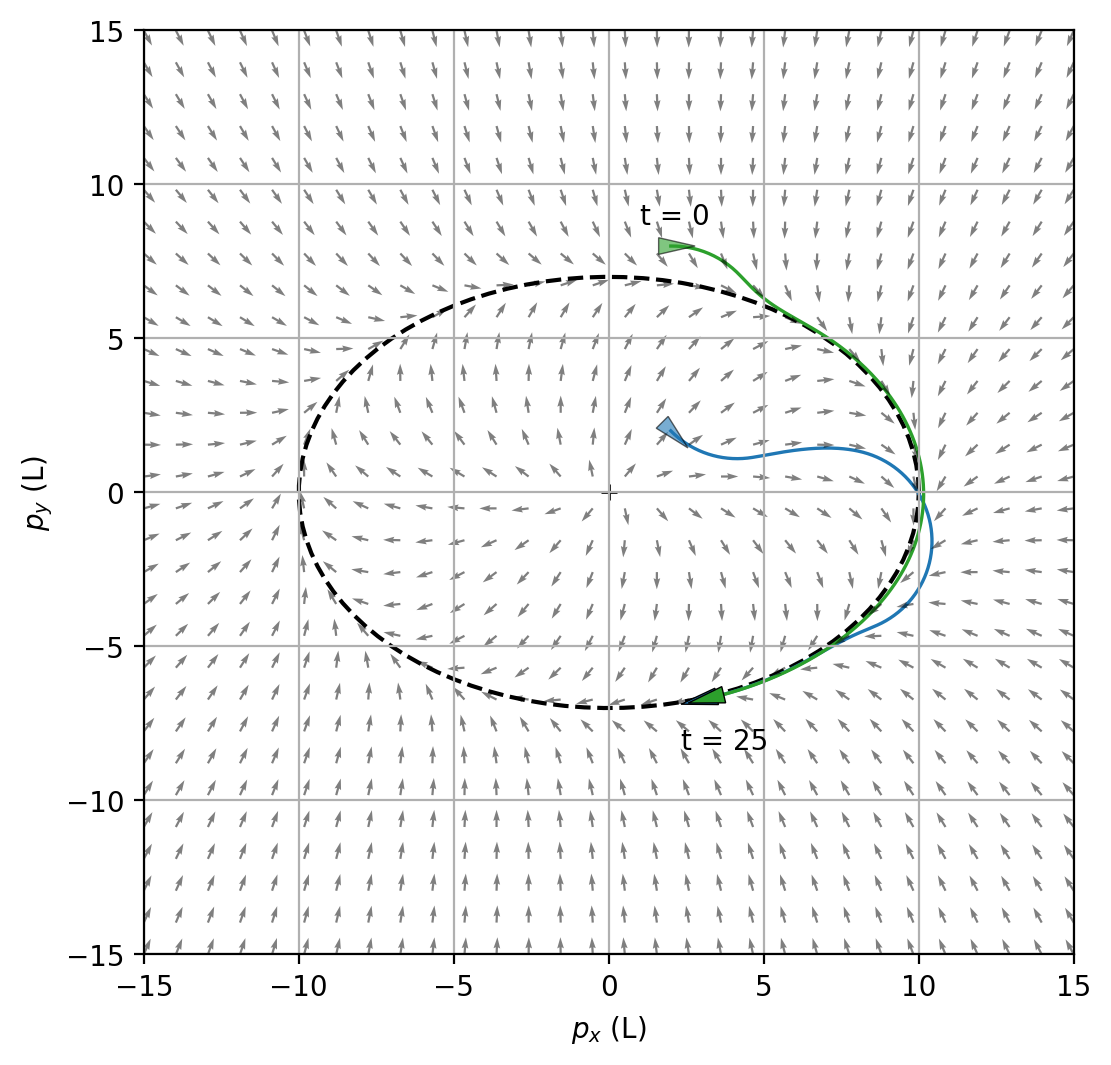

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(6, 6), dpi=200)
grid = plt.GridSpec(1, 1)
main_ax = fig.add_subplot(grid[:,:])

# Axis configuration
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

# Main axis
draw(gvf_traj, fig, main_ax)


li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[n*2]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  icon.set_label("n"+str(n))

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

plt.text(xdata[0,1]-1, ydata[0,1]+0.7, "t = {0:.0f}".format(0))
plt.text(xdata[li,1]-1, ydata[li,1]-1.7, "t = {0:.0f}".format(t_sim_final))

plt.savefig('GVF_CBF_intro1.png')
plt.show()

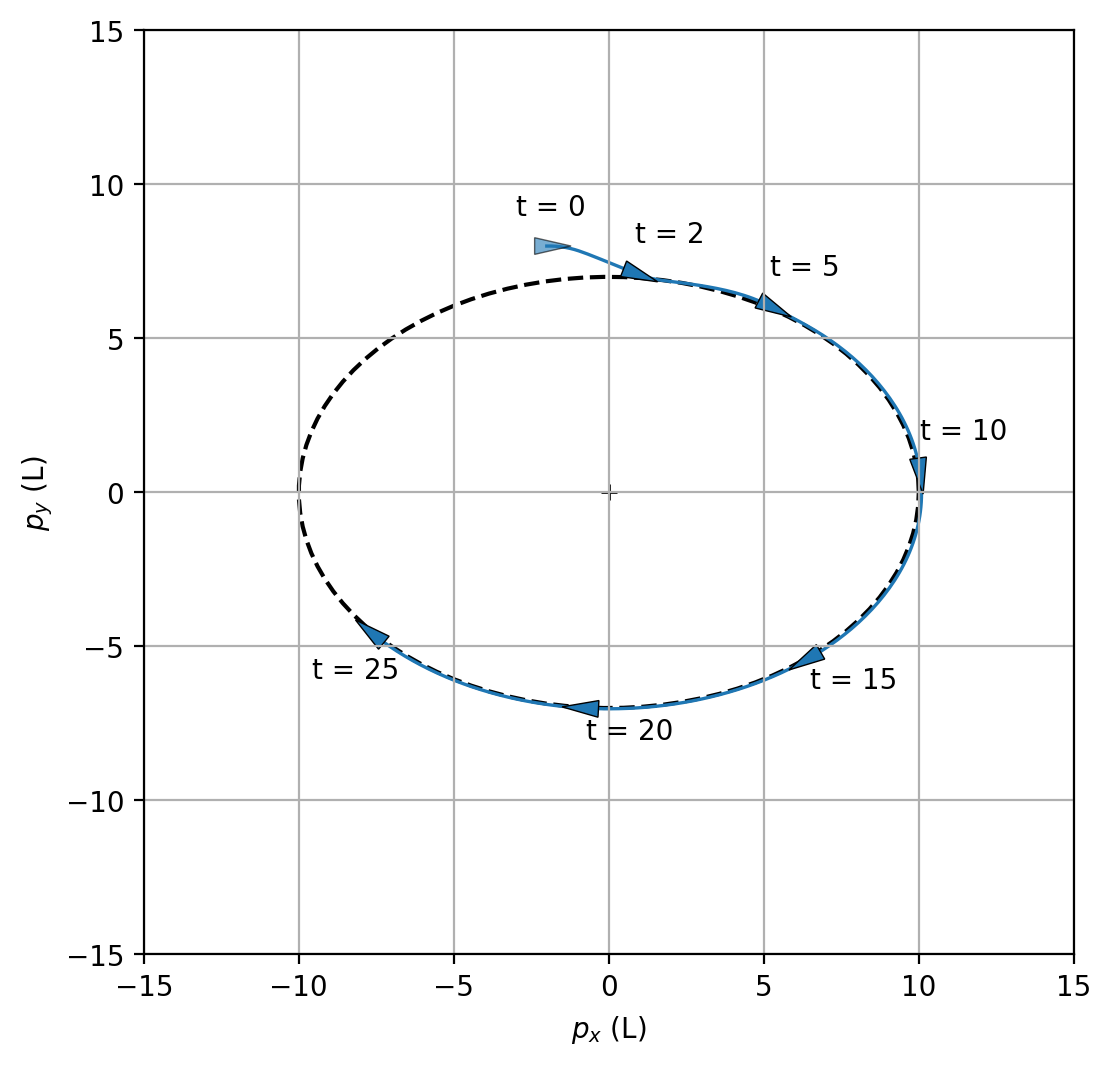

In [ ]:
# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

fig = plt.figure(figsize=(6, 6), dpi=200)
grid = plt.GridSpec(1, 1)
main_ax = fig.add_subplot(grid[:,:])

# Axis configuration
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

# Main axis
draw(gvf_traj, fig, main_ax, draw_field=False)

li = xdata.shape[0] - 1
n = 1

color = color_palette()[0]
icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
icon_init.set_alpha(0.6)
icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)

main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
main_ax.add_patch(icon_init)
main_ax.add_patch(icon)

# Inicio y final
plt.text(xdata[0,n]-1, ydata[0,n]+1, "t = {0:.0f}".format(0))
plt.text(xdata[li,n]-2, ydata[li,n]-1.4, "t = {0:.0f}".format(t_sim_final))

# Waypoints
t_list = [2,5,10,15,20]

for t in t_list:
  li = int(t/dt)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  main_ax.add_patch(icon)
  if ydata[li,n] > 0:
    plt.text(xdata[li,n], ydata[li,n]+1, "t = {0:.0f}".format(t))
  else:
    plt.text(xdata[li,n], ydata[li,n]-1, "t = {0:.0f}".format(t))

plt.savefig('GVF_CBF_intro2.png')
plt.show()

## PLOT: Notación y gráficos ilustrativos

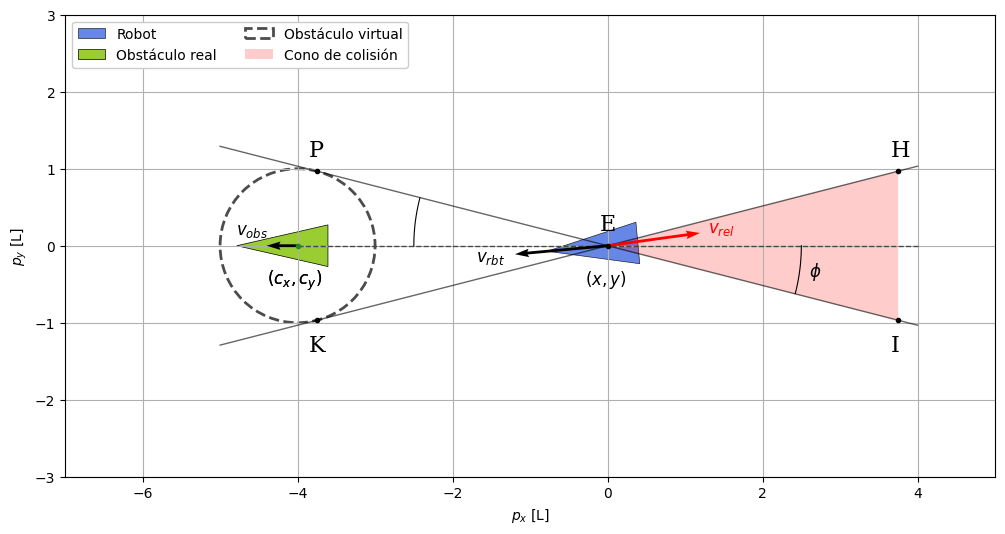

In [ ]:
# ----------------------------
# C3BF - Gráficos de notación
# ----------------------------

# Parámetros
col_rad = 1

rbt_xy = np.array([ 0, 0])
obs_xy = np.array([-4, 0])
rbt_phi = -np.pi/1.03
obs_phi = np.pi
# ----------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (12, 6), dpi = 100)
ax = fig.subplots()

ax.set_xlim([-7,5])
ax.set_ylim([-3,3])
ax.set_xlabel(r"$p_x$ [L]")
ax.set_ylabel(r"$p_y$ [L]")
ax.grid(True)

# Dibujamos el robot
icon_rbt = unicycle_patch(rbt_xy, rbt_phi, "royalblue")
icon_rbt.set_alpha(0.8)
icon_rbt.set_label("Robot")
ax.add_patch(icon_rbt)

# Dibujamos el obstáculo
icon_obs = unicycle_patch(obs_xy, obs_phi, "yellowgreen")
icon_col = patches.Circle(obs_xy, col_rad, alpha=0.7, fill=False,
                          color="k", ls="--", lw=2)
ax.add_patch(icon_obs)
ax.add_patch(icon_col)

# Dibujamos el cono
P, K = cone_params(obs_xy, col_rad, rbt_xy)
I, H = cone_params(-obs_xy, col_rad, rbt_xy)

cone = patches.Polygon(np.array([rbt_xy, H, I]), alpha=0.2,
                       color="red", zorder=1, lw=0)
ax.add_patch(cone)

# Dibujamos puntos
pts = np.array([[0,0],H,I,P,K])
ax.plot(pts[:,0], pts[:,1], ".k", zorder=3)
ax.plot(obs_xy[0], obs_xy[1], ".", c="forestgreen", zorder=4)

# Dibujamos rectas
x_draw  = np.linspace(-5,4,100)
x_draw2 = np.linspace(-4,0,100)

ax.plot(x_draw, (K[1]-H[1])/(K[0]-H[0])*x_draw, "-k", lw=1, alpha=0.6)
ax.plot(x_draw, (P[1]-I[1])/(P[0]-I[0])*x_draw, "-k", lw=1, alpha=0.6)
ax.plot( x_draw2, 0*x_draw2, "--k", lw=1, alpha=0.6)
ax.plot(-x_draw2, 0*x_draw2, "--k", lw=1, alpha=0.6)

# Dibujamos vectores
arr_kw = {"width":0.003, "scale":10, "zorder":2}

v_rel_x = (np.cos(obs_phi) - 3*np.cos(rbt_phi))/2
v_rel_y = (np.sin(obs_phi) - 3*np.sin(rbt_phi))/2
ax.quiver(rbt_xy[0], rbt_xy[1], v_rel_x, v_rel_y, color="red", **arr_kw)
ax.quiver(rbt_xy[0], rbt_xy[1], np.cos(rbt_phi), np.sin(rbt_phi), color="k", **arr_kw)
ax.quiver(obs_xy[0], obs_xy[1], np.cos(obs_phi)/3, np.sin(obs_phi)/3, color="k", **arr_kw)

# Dibujamos arcos
r = 2.5
x_arc1 = np.linspace(-r, -r*np.cos(np.pi/12.5), 100)
x_arc2 = np.linspace(r*np.cos(np.pi/12.5), r , 100)

ax.plot(x_arc1,  np.sqrt(r**2 - x_arc1**2), "-k", lw=0.8)
ax.plot(x_arc2, -np.sqrt(r**2 - x_arc2**2), "-k", lw=0.8)

# Dibujamos los textos
ax.text(2.6,-0.4, r"$\phi$",  fontsize=12)
ax.text(-0.29,-0.5, r"$(x,y)$", fontsize=12)
ax.text(-4.4,-0.5, r"$(c_x,c_y)$", fontsize=12)

ax.text(-0.1,0.2, "E", fontsize=16, fontfamily="serif")
ax.text(I[0]-0.1, I[1]-0.4, "I",  fontsize=16, fontfamily="serif")
ax.text(H[0]-0.1, H[1]+0.2, "H",  fontsize=16, fontfamily="serif")
ax.text(K[0]-0.1, K[1]-0.4, "K",  fontsize=16, fontfamily="serif")
ax.text(P[0]-0.1, P[1]+0.2, "P",  fontsize=16, fontfamily="serif")

ax.text(1.3, 0.17, r"$v_{rel}$", c="red", fontsize=12)
ax.text(-1.7, -0.2, r"$v_{rbt}$", fontsize=12)
ax.text(-4.8, 0.15, r"$v_{obs}$", fontsize=12)
ax.text(-4.4,-0.5, r"$(c_x,c_y)$", fontsize=12)

# Legenda
icon_obs.set_label("Obstáculo real")
icon_col.set_label("Obstáculo virtual")
cone.set_label("Cono de colisión")
plt.legend(loc="upper left", ncol=2, fancybox=True, framealpha=1)

# Guardamos y dibujamos la figura
plt.savefig('C3BF_0.png')
plt.show()

## PLOT: C3BF - Visualización del cono

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 40

# Constantes de los controladores
ke = 4
kn = 2

r = 1
gamma = 0.9

# Estado inicial de los agentes y número de agentes
n_agents = 2
p0 = np.array([[2, 8], [0, -7]])
v0 =  np.array([[0.9, 0]]).T
phi0 = np.pi - np.array([np.pi, 0])

x0 = [t0, p0, v0, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = gvf_simulation(gvf_traj, rover_kinematics, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Realizamos toda la simulación mumerica
xdata, ydata = [], []
phidata = []
hdata = []
psi_data = []
kappa_data = []

for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)

    hdata.append(sim.h)
    psi_data.append(sim.psi)
    kappa_data.append(sim.kappa)
  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

hdata = np.array(hdata)
psi_data = np.array(psi_data)
kappa_data = np.array(kappa_data)

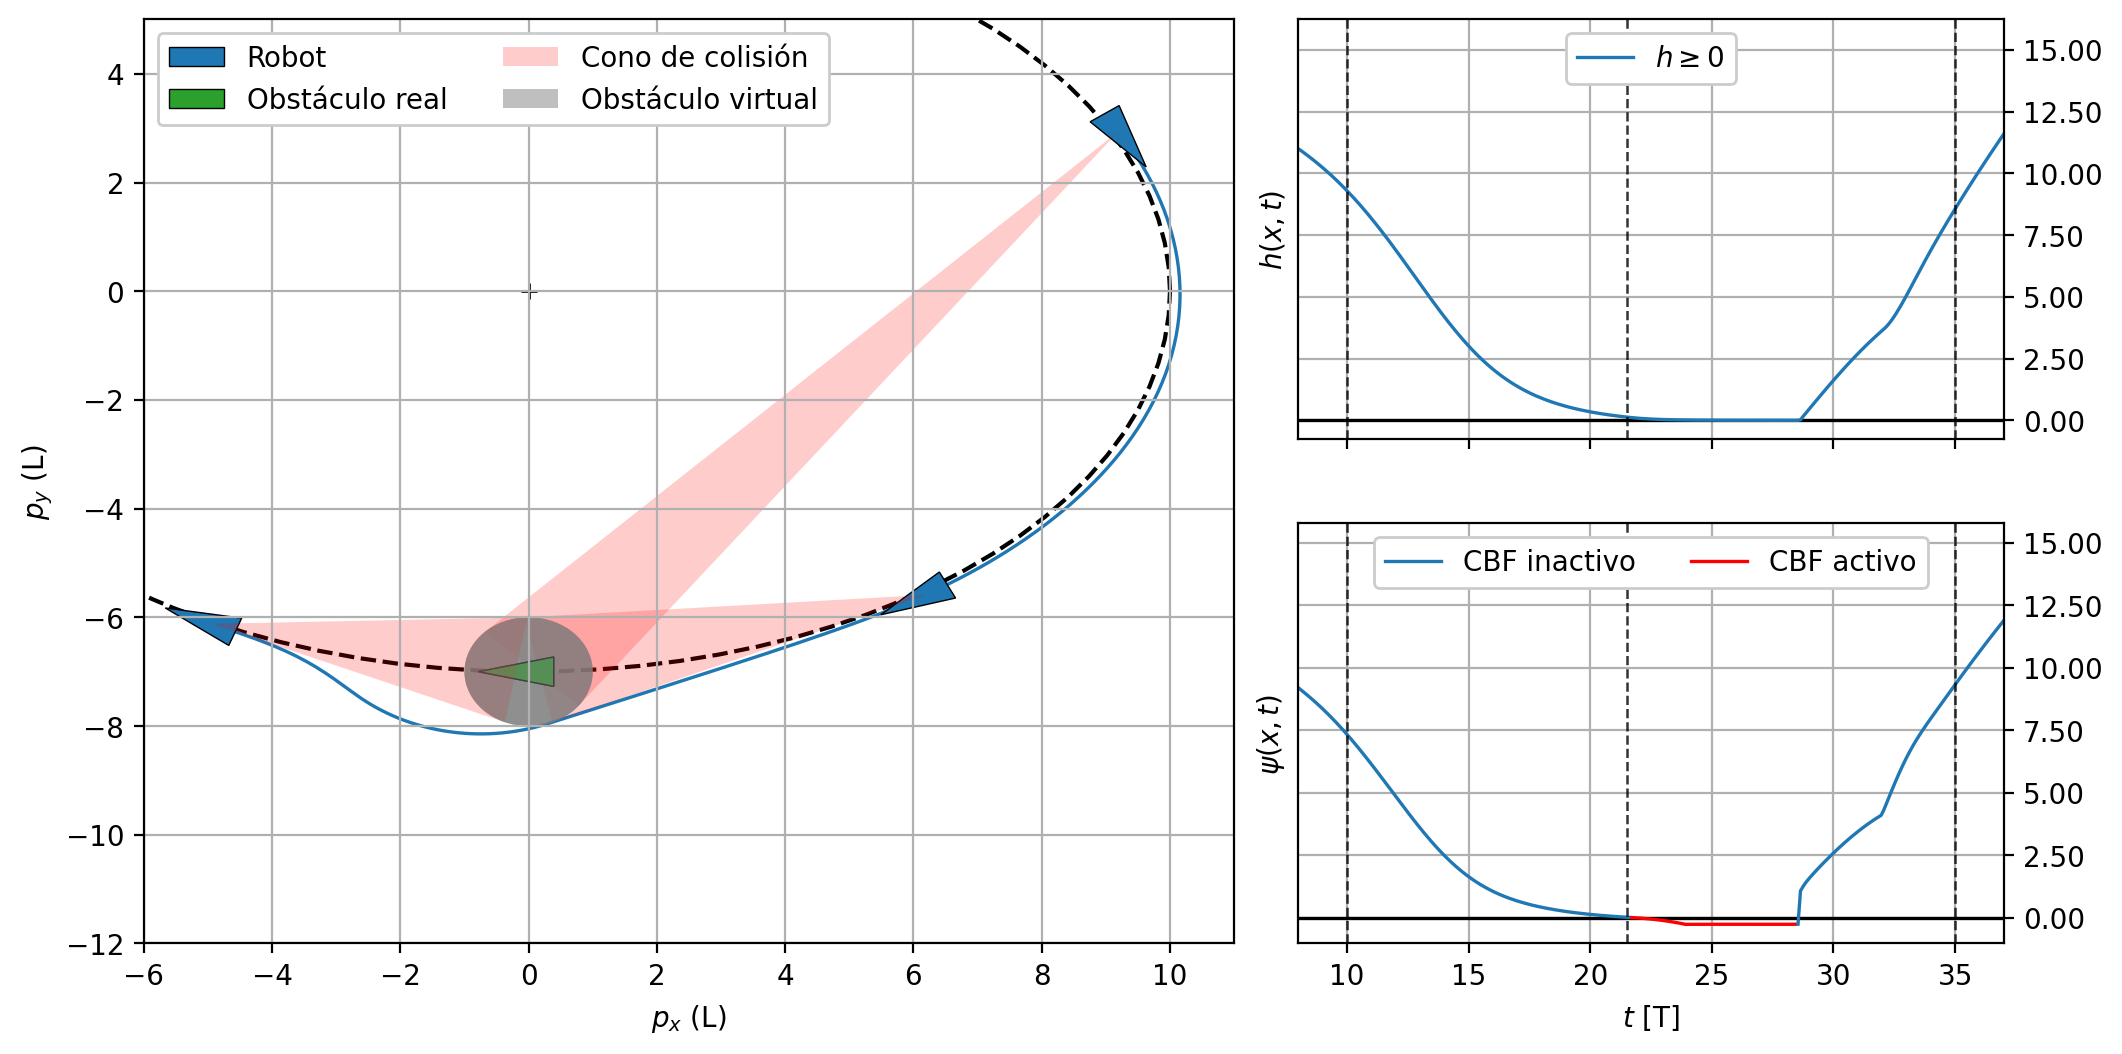

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# -- Preliminares --
n_rbt = 0
n_obs = 1
color_rbt = color_palette()[0]
color_obs = color_palette()[2]
t_list = np.array([10,21.5,35])

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

# Inicializamos las figuras y el grid
fig = plt.figure(figsize=(12, 6), dpi=200)
grid = plt.GridSpec(2, 5, hspace=0.2, wspace=0.2)
main_ax    = fig.add_subplot(grid[:,0:3])
hdata_ax   = fig.add_subplot(grid[0,3:5], xticklabels=[])
psidata_ax = fig.add_subplot(grid[1,3:5])

# Configuramos los ejes
main_ax.set_xlim([-6,11])
main_ax.set_ylim([-12,5])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True, zorder=0)

fmt_data_axis(hdata_ax, r"$h(x,t)$",
              xlim=[t_list[0]-2,t_list[-1]+2])
fmt_data_axis(psidata_ax, r"$\psi(x,t)$", r"$t$ [T]",
              xlim=[t_list[0]-2,t_list[-1]+2])

# Main axis ##
draw(gvf_traj, fig, main_ax, draw_field=False)

# -- Dibujamos los patches --
for t in t_list:
  li = int(t/dt)-1
  rbt_xy = [xdata[li,n_rbt], ydata[li,n_rbt]]
  obs_xy = [xdata[li,n_obs], ydata[li,n_obs]]

  # Dibujamos el robot
  icon_rbt = unicycle_patch([xdata[li,n_rbt], ydata[li,n_rbt]],
                            phidata[li,n_rbt], color_rbt)
  icon_obs = unicycle_patch([xdata[li,n_obs], ydata[li,n_obs]],
                            phidata[li,n_obs], color_obs)
  #icon_rbt.set_alpha(0.6)
  main_ax.add_patch(icon_rbt)
  main_ax.add_patch(icon_obs)

  # Dibujamos el cono
  p1, p2 = cone_params(obs_xy, r, rbt_xy)
  cone = patches.Polygon(np.array([rbt_xy, p1, p2]),
                        alpha=0.2, color="red", zorder=1, lw=0)
  icon_col = patches.Circle(obs_xy, r,
                  alpha=0.5, fill=True, color="gray", ls="-", lw=0)
  main_ax.add_patch(cone)
  main_ax.add_patch(icon_col)

    # Etiquetas
  if t == t_list[0]:
    icon_rbt.set_label("Robot")
    icon_obs.set_label("Obstáculo real")
    icon_col.set_label("Obstáculo virtual")
    cone.set_label("Cono de colisión")

# -- Dibujamos la traza --
li, lf = int(t_list[0]/dt)-1, int(t_list[-1]/dt)-1
main_ax.plot(xdata[li:lf,n_rbt],ydata[li:lf,n_rbt], c=color_rbt,
             ls="-", lw=1.2, zorder=0)

# Data axis ##
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
hdata_ax.axhline(0, c="k", ls="-", lw=1.2, zorder=2)
psidata_ax.axhline(0, c="k", ls="-", lw=1.2, zorder=2)

# Plotting data
mask_active = psi_data[:,1,0] < 0

l1 = np.where(mask_active)[0][0]
l2 = np.where(mask_active)[0][-1]

psidata_ax.plot(time_vec[0:l1], psi_data[0:l1,1,0], c=color_rbt, lw=1.2,
                label="CBF inactivo")
psidata_ax.plot(time_vec[l1:l2], psi_data[l1:l2,1,0], c="red", lw=1.2,
                label="CBF activo")
psidata_ax.plot(time_vec[l2:], psi_data[l2:,1,0], c=color_rbt, lw=1.2)

hdata_ax.plot(time_vec, hdata[:,1,0], c=color_rbt, lw=1.2, label=r"$h \geq 0$")

# Vertical lines
for t in t_list:
  hdata_ax.axvline(t, c="k", ls="--", lw=0.9, zorder=2, alpha=0.8)
  psidata_ax.axvline(t, c="k", ls="--", lw=0.9, zorder=2, alpha=0.8)

# -- Visualizamos y guardamos --
main_ax.legend(loc="upper left", ncol=2, fancybox=True, framealpha=1)
hdata_ax.legend(loc="upper center", ncol=2, fancybox=True, framealpha=1)
psidata_ax.legend(loc="upper center", ncol=2, fancybox=True, framealpha=1)

plt.savefig('C3BF_1.png')
plt.show()

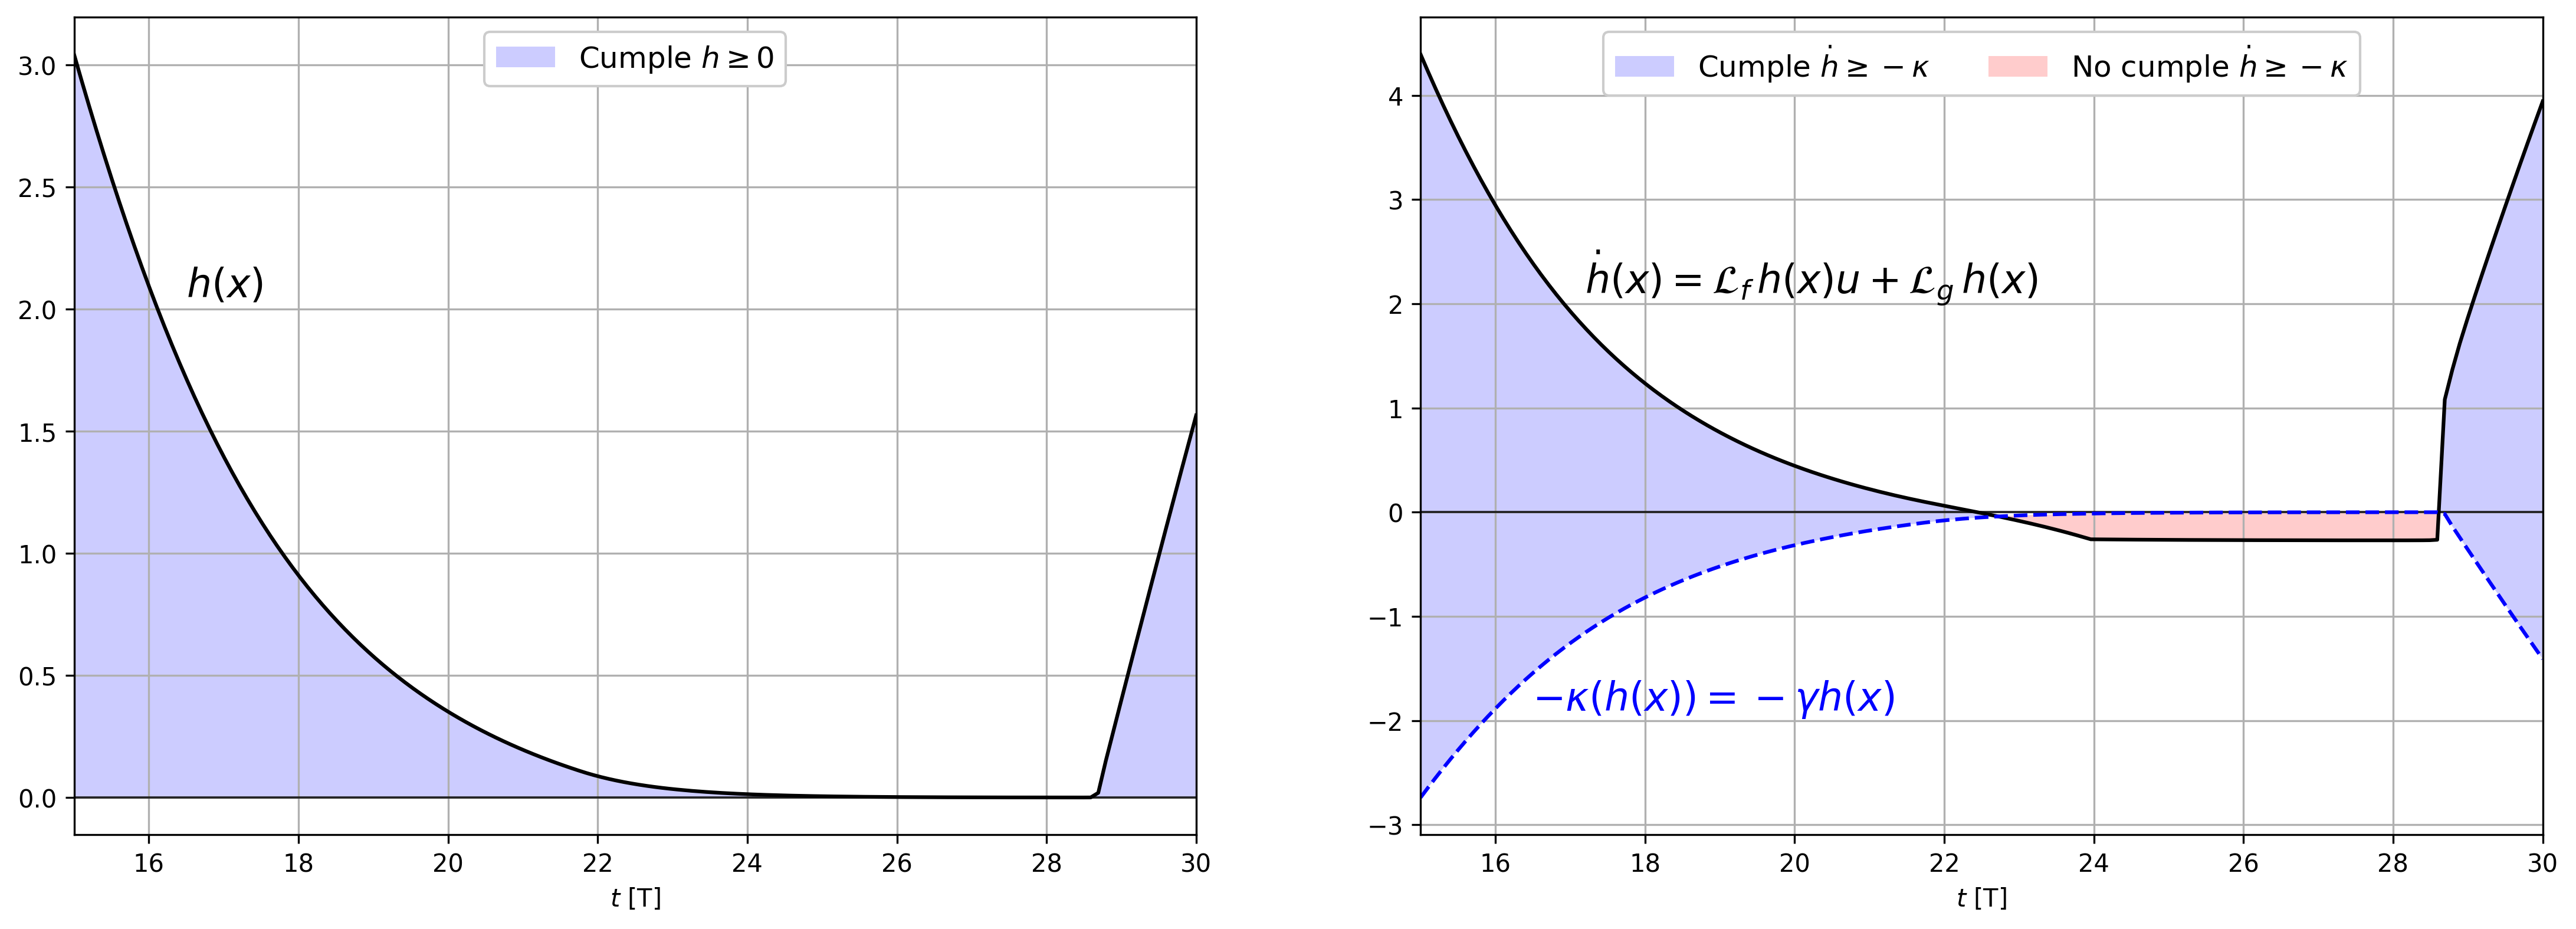

In [ ]:
# -----------------------------
# CBF - Gráficos ilustrativos
# -----------------------------

# Preliminares
t1, t2 = 15, 30
li, lf = int(t1/dt-1), int(t2/dt-1)

# Rango de evaluación en x
x_eval = np.linspace(t1, t2, int((t2-t1)/dt))
h_eval = hdata[li:lf,1,0]
kappa_eval = -kappa_data[li:lf,1,0]
h_dot_eval  = psi_data[li:lf,1,0] - kappa_eval

# --------------------------------------------
# Inicialización y configuración de la figuras
fig = plt.figure(figsize = (18, 6), dpi = 300)
grid = plt.GridSpec(1, 2, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(grid[:,0])
ax2 = fig.add_subplot(grid[:,1])

# Configuración de los ejes
ax1.set_xlim([t1,t2])
ax1.set_xlabel(r"$t$ [T]")
ax1.set_ylabel(r"")
ax1.grid(True)

ax2.set_xlim([t1,t2])
ax2.set_xlabel(r"$t$ [T]")
ax2.set_ylabel(r"")
ax2.grid(True)

# Graficamos
ax1.axhline(0, c="k", ls="-", lw=0.9, zorder=2, alpha=0.8)
ax1.plot(x_eval, h_eval, "k")

ax2.axhline(0, c="k", ls="-", lw=0.9, zorder=2, alpha=0.8)
ax2.plot(x_eval, h_dot_eval, "-k")
ax2.plot(x_eval, kappa_eval, "--b")

# Dibujamos el área
mask_active = h_dot_eval < kappa_eval

l1 = np.where(mask_active)[0][0]
l2 = np.where(mask_active)[0][-1]

area_pts0 = np.c_[np.array([x_eval, h_eval]),
                  np.array([np.flip(x_eval), 0*x_eval])].T
area_pts1 = np.c_[np.array([x_eval[:l1], h_dot_eval[:l1]]),
                  np.array([np.flip(x_eval[:l1]),
                            np.flip(kappa_eval[:l1])])].T
area_pts2 = np.c_[np.array([x_eval[l1:l2+1], h_dot_eval[l1:l2+1]]),
                  np.array([np.flip(x_eval[l1:l2+1]),
                            np.flip(kappa_eval[l1:l2+1])])].T
area_pts3 = np.c_[np.array([x_eval[l2:], h_dot_eval[l2:]]),
                  np.array([np.flip(x_eval[l2:]),
                            np.flip(kappa_eval[l2:])])].T

area0 = patches.Polygon(area_pts0, alpha=0.2, color="blue", zorder=1, lw=0,
                        label="Cumple $h \geq 0$")
area1 = patches.Polygon(area_pts1, alpha=0.2, color="blue", zorder=1, lw=0,
                        label="Cumple $\dot h \geq -\kappa$")
area2 = patches.Polygon(area_pts2, alpha=0.2, color="red", zorder=1, lw=0,
                        label="No cumple $\dot h \geq -\kappa$")
area3 = patches.Polygon(area_pts3, alpha=0.2, color="blue", zorder=1, lw=0)

ax1.add_patch(area0)
ax2.add_patch(area1)
ax2.add_patch(area2)
ax2.add_patch(area3)

# Texto
ax1.text(16.5, 2.05, r"$h(x)$", fontsize=16, c="k")

ax2.text(17.2, 2.1, r"$\dot h(x) = \mathcal{L}_f\,h(x)u + \mathcal{L}_g\,h(x)$",
         fontsize=16, c="k")
ax2.text(16.5, -1.9, r"$- \kappa(h(x)) = - \gamma h(x)$",
         fontsize=16, c="b")

# Guardamos la figura y visualizamos
ax1.legend(loc="upper center", ncol=1, fancybox=True, framealpha=1, fontsize=12)
ax2.legend(loc="upper center", ncol=2, fancybox=True, framealpha=1, fontsize=12)

plt.savefig('CBF_1.png')
plt.show()

## PLOT: Simulación GVF + CBF adaptada al experimento

In [ ]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 20

# Constantes de los controladores
ke = 4
kn = 2

r = 1
gamma = 2

# Estado inicial de los agentes y número de agentes
n_agents = 3
p0 = np.array([[2, 2], [-2, 2], [3, -3]])
v0 =  np.array([[1.5,2.3,4]]).T
phi0 = np.pi - np.array([-3*np.pi/4, -np.pi/4, np.pi/4])

x0 = [t0, p0, v0, phi0]

In [ ]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = gvf_simulation(gvf_traj, rover_kinematics, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
omega_safe_data = []
edata = []
phidata = []
psi_data = []

dot_rel_data = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)
    edata.append(sim.e)

    psi_data.append(sim.psi)
    dot_rel_data.append(sim.dot_rel)
    omega_safe_data.append(sim.omega_safe)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)
edata = np.array(edata)

omega_safe_data = np.array(omega_safe_data)
dot_rel_data = np.array(dot_rel_data)
psi_data = np.array(psi_data)

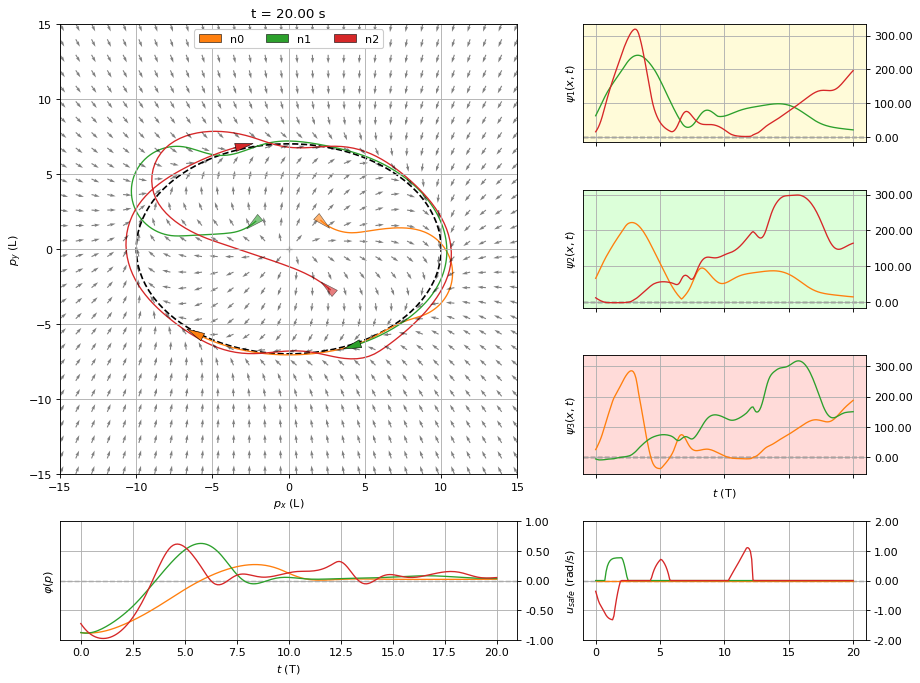

In [ ]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(13, 10)
dpi=80

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(4, 5, hspace=0.4, wspace=0.6)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[0:3, 0:3])
edata_ax     = fig.add_subplot(grid[3, 0:3])
wsafedata_ax = fig.add_subplot(grid[3, 3:5])


psi1_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
psi2_ax = fig.add_subplot(grid[1, 3:5], xticklabels=[])
psi3_ax = fig.add_subplot(grid[2, 3:5], xticklabels=[])
psi_axis = [psi1_ax, psi2_ax, psi3_ax]

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(wsafedata_ax, r"$u_{safe}$ (rad/s)", ylim=[-2,2])
fmt_data_axis(edata_ax, r"$\varphi(p)$", r"$t$ (T)", ylim=[-1,1])

fmt_data_axis(psi1_ax, r"$\psi_1(x,t)$")
fmt_data_axis(psi2_ax, r"$\psi_2(x,t)$")
fmt_data_axis(psi3_ax, r"$\psi_3(x,t)$", r"$t$ (T)")

# Background color
psi1_ax.patch.set_facecolor(cake_y)
psi2_ax.patch.set_facecolor(cake_g)
psi3_ax.patch.set_facecolor(cake_r)

## Main axis ----------------
draw(gvf_traj, fig, main_ax)
main_ax.set_title("t = {0:.2f} s".format(t_sim_final))

li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[n+1]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  icon.set_label("n"+str(n+1))

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)

## Data axis ----------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  color = color_palette()[n+1]
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], c=color, lw=1.2)
  edata_ax.plot(time_vec, edata[:,n], c=color, lw=1.2)
  for k in range(sim.N):
    if k != n:
      color = color_palette()[k+1]
      psi_axis[n].plot(time_vec, psi_data[:,k,n], c=color, lw=1.2)
      psi_axis[n].axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

plt.show()

In [ ]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

n_tail  = 250
figsize = (13, 10)
dpi     = 100

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(4, 5, hspace=0.4, wspace=0.6)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[0:3, 0:3])
edata_ax     = fig.add_subplot(grid[3, 0:3])
wsafedata_ax = fig.add_subplot(grid[3, 3:5])


psi1_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
psi2_ax = fig.add_subplot(grid[1, 3:5], xticklabels=[])
psi3_ax = fig.add_subplot(grid[2, 3:5], xticklabels=[])
psi_axis = [psi1_ax, psi2_ax, psi3_ax]

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(wsafedata_ax, r"$u_{safe}$ (rad/s)", ylim=[-2,2])
fmt_data_axis(edata_ax, r"$\varphi(p)$", r"$t$ (T)", ylim=[-1,1])

fmt_data_axis(psi1_ax, r"$\psi_1(x,t)$")
fmt_data_axis(psi2_ax, r"$\psi_2(x,t)$")
fmt_data_axis(psi3_ax, r"$\psi_3(x,t)$", r"$t$ (T)")

# Background color
psi1_ax.patch.set_facecolor(cake_b)
psi2_ax.patch.set_facecolor(cake_y)
psi3_ax.patch.set_facecolor(cake_g)

# -------------
# Main ax init
# -------------
draw(gvf_traj, fig, main_ax)

lines_plt = []
icons_plt = []
c_palet = color_palette()
for n in range(sim.N):
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
  icon_init.set_alpha(0.6)
  icon_init.set_label("n"+str(n+1))


  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[:,n], ydata[:,n], c=c_palet[n],
                       ls="-", lw=0.8)

  lines_plt.append(line)
  icons_plt.append(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)
txt_title = main_ax.set_title("")

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

data_lines_plt = []
psilines = []
for n in range(sim.N):
  kw = dict(c=c_palet[n], lw=1.2)
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], **kw)
  edata_ax.plot(time_vec, edata[:,n], **kw)
  for k in range(sim.N):
    if k != n:
      color = c_palet[k]
      psi_axis[n].plot(time_vec, psi_data[:,k,n], c=color, lw=1.2)
      psi_axis[n].axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
  psilines.append(psi_axis[n].axvline(0, c="black", ls="--", lw=1.2))

wline = wsafedata_ax.axvline(0, c="black", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="black", ls="--", lw=1.2)

# Plotting data
for n in range(sim.N):
  color = c_palet[n]
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], c=color, lw=1.2)
  edata_ax.plot(time_vec, edata[:,n], c=color, lw=1.2)
  for k in range(sim.N):
    if k != n:
      color = c_palet[k]
      psi_axis[n].plot(time_vec, psi_data[:,k,n], c=color, lw=1.2)
      psi_axis[n].axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_plt[n].remove()
    icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], c_palet[n])
    icons_plt[n].set_zorder(3)

    main_ax.add_patch(icons_plt[n])
    psilines[n].set_xdata(i*dt)

    # Dibujamos la cola
    if i > n_tail:
      lines_plt[n].set_data(xdata[i-n_tail:i,n], ydata[i-n_tail:i,n])
    else:
      lines_plt[n].set_data(xdata[0:i,n], ydata[0:i,n])

  # Actualizamos el título
  txt_title.set_text('Frame = {0:>4} | Tf = {1:>5.2f} s'.format(i, i*dt))

  wline.set_xdata(i*dt)
  eline.set_xdata(i*dt)

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((xdata.shape[0]-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(xdata.shape[0]-1)))

# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=xdata.shape[0], interval=20)

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf =  1.90 | 9.60%
tf =  3.80 | 19.19%
tf =  5.70 | 28.79%
tf =  7.60 | 38.38%
tf =  9.50 | 47.98%
tf = 11.40 | 57.58%
tf = 13.30 | 67.17%
tf = 15.20 | 76.77%
tf = 17.10 | 86.36%
tf = 19.00 | 95.96%


## ANIMACIÓN: Simulación GVF + CBF

In [43]:
# ----------------------------------------------------------------------
# Parámetros de la trayectoria
# ----------------------------------------------------------------------
XYoff = [0, 0]
a, b = 10, 7
alpha = 0

# Generamos la trayectoria
gvf_traj = gvf_ellipse(XYoff,alpha,a,b)

# Parámetros del campo
s = 1
area = 30**2
XYoff_vfield = XYoff

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.1
t0 = 0
t_sim_final = 50

# Constantes de los controladores
ke = 4
kn = 2

r = 1
gamma = 2

# Estado inicial de los agentes y número de agentes
n_agents = 4
p0 = np.array([[2, 2], [-2, 2], [3, -3], [2, -2]])
v0 =  np.array([[1.5,2.3,1,1]]).T
phi0 = np.pi - np.array([-3*np.pi/4, -np.pi/4, np.pi/4, 3*np.pi/4])

x0 = [t0, p0, v0, phi0]

In [44]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
sim = gvf_simulation(gvf_traj, rover_kinematics, n_agents, x0, dt, True)
sim.set_params(s, ke, kn, r, gamma)

# Generamos el campo (sin interacción de repulsión)
gvf_traj.vector_field(XYoff_vfield, area, s, ke)

# Inicializamos
xdata, ydata = [], []
phidata = []

omega_safe_data = []
edata = []

# Realizamos toda la simulación mumerica
for i in range(int(t_sim_final/dt)):
  if i != 0:
    xdata.append(sim.pf[:,0])
    ydata.append(sim.pf[:,1])
    phidata.append(sim.phif)

    omega_safe_data.append(sim.omega_safe)
    edata.append(sim.e)

  sim.int_euler()

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = np.array(xdata)
ydata = np.array(ydata)
phidata = np.array(phidata)

omega_safe_data = np.array(omega_safe_data)
edata = np.array(edata)

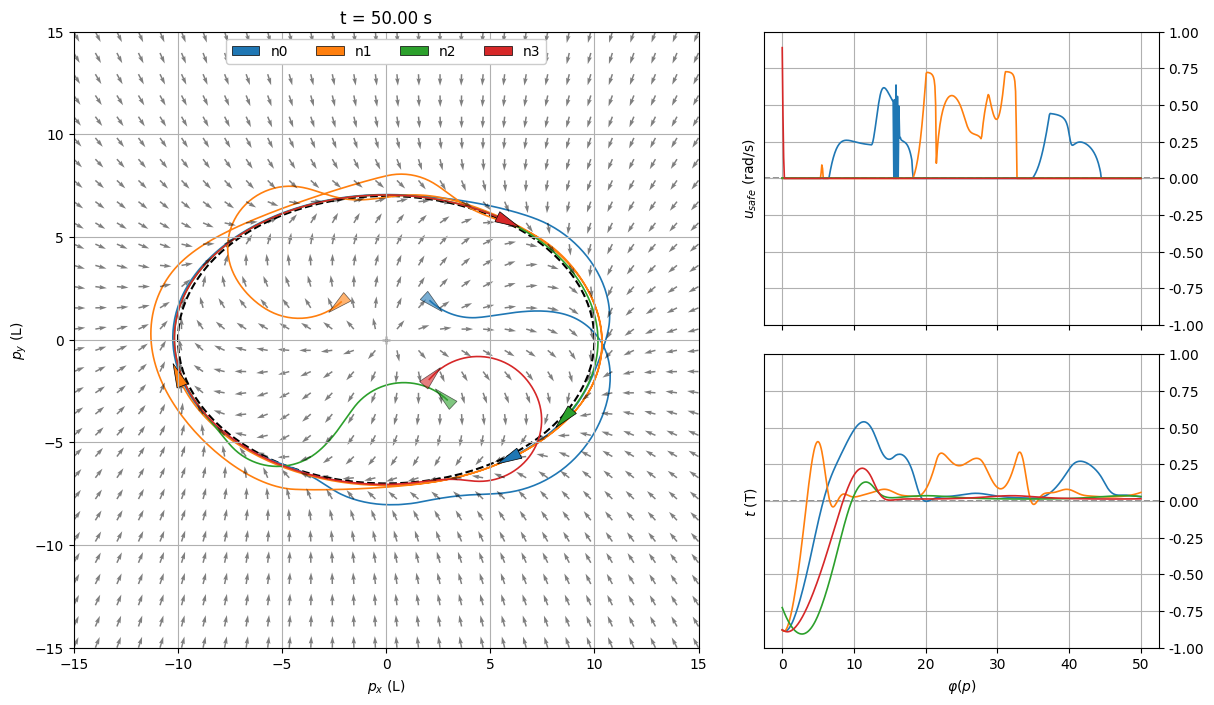

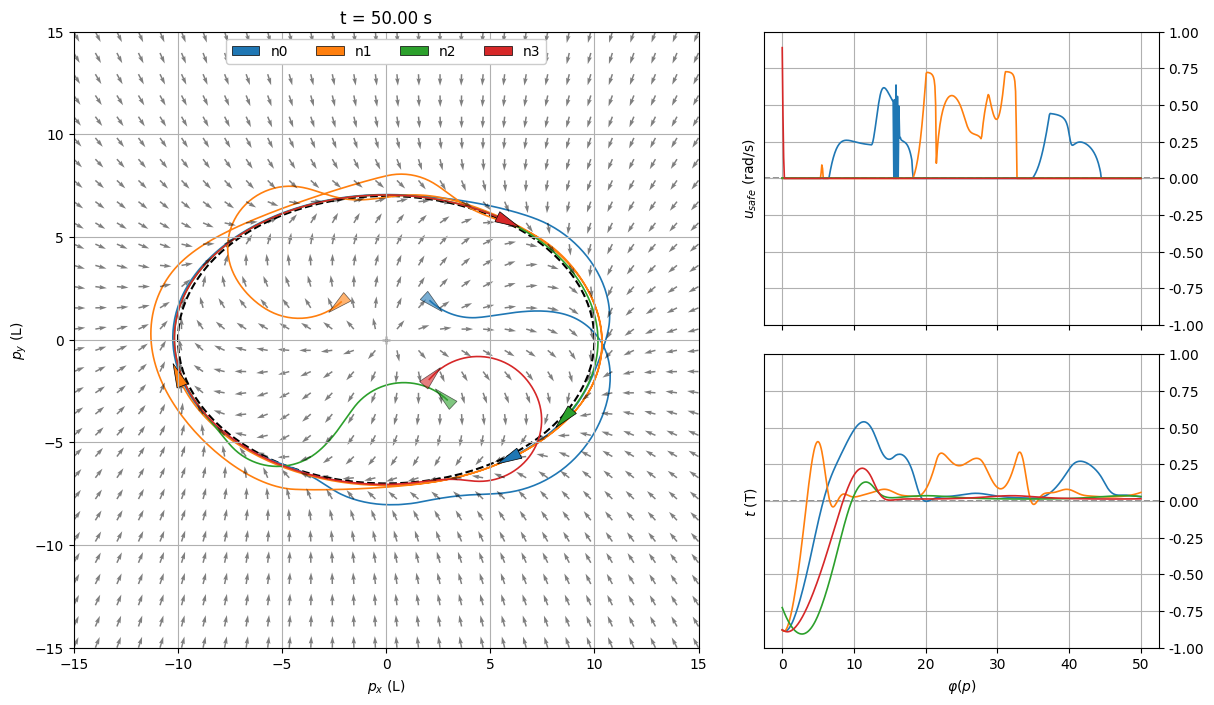

In [46]:
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

# ----------------------------------------------------------------------
# Mostramos el estado final de la simulación (static plot)
# ----------------------------------------------------------------------

figsize=(14, 8)
dpi=100

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
wsafedata_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
edata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(wsafedata_ax, ylabel = r"$u_{safe}$ (rad/s)", ylim=[-1,1])
fmt_data_axis(edata_ax, r"$t$ (T)", r"$\varphi(p)$", ylim=[-1,1])

# Main axis ----------------
draw(gvf_traj, fig, main_ax)
main_ax.set_title("t = {0:.2f} s".format(t_sim_final))

li = xdata.shape[0] - 1
for n in range(sim.N):
  color = color_palette()[n]
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], color)
  icon_init.set_alpha(0.6)
  icon = unicycle_patch([xdata[li,n], ydata[li,n]], phidata[li,n], color)
  icon.set_label("n"+str(n))

  main_ax.plot(xdata[:,n],ydata[:,n], c=color, ls="-", lw=1.2, zorder=0)
  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)

# Data axis ----------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

# Plotting data
for n in range(sim.N):
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], c=color_palette()[n], lw=1.2)
  edata_ax.plot(time_vec, edata[:,n], c=color_palette()[n], lw=1.2)

plt.show()

In [47]:
# Activamos la graficación interactiva (necesario para animar en notebooks)
%matplotlib notebook
%matplotlib notebook

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------

n_tail = 250
figsize=(14, 8)
dpi=80

# Inicialización de las figuras y el grid
fig = plt.figure(figsize=figsize, dpi=dpi)
grid = plt.GridSpec(2, 5, hspace=0.1, wspace=0.4)

# Inicialización de los ejes
main_ax      = fig.add_subplot(grid[:, 0:3])
wsafedata_ax = fig.add_subplot(grid[0, 3:5], xticklabels=[])
edata_ax     = fig.add_subplot(grid[1, 3:5])

# Se da formato a los ejes
main_ax.set_xlim([-15,15])
main_ax.set_ylim([-15,15])
main_ax.set_ylabel(r"$p_y$ (L)")
main_ax.set_xlabel(r"$p_x$ (L)")
main_ax.grid(True)

fmt_data_axis(wsafedata_ax, ylabel = r"$u_{safe}$ (rad/s)", ylim=[-1,1])
fmt_data_axis(edata_ax, r"$t$ (T)", r"$\varphi(p)$", ylim=[-1,1])

# -------------
# Main ax init
# -------------
draw(gvf_traj, fig, main_ax)

lines_plt = []
icons_plt = []
c_palet = color_palette()
for n in range(sim.N):
  icon = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
  icon_init = unicycle_patch([xdata[0,n], ydata[0,n]], phidata[0,n], c_palet[n])
  icon_init.set_alpha(0.6)
  icon_init.set_label("n"+str(n))


  main_ax.add_patch(icon_init)
  main_ax.add_patch(icon)
  line, = main_ax.plot(xdata[:,n], ydata[:,n], c=c_palet[n],
                       ls="-", lw=0.8)

  lines_plt.append(line)
  icons_plt.append(icon)

main_ax.legend(loc="upper center", ncol=sim.N, fancybox=True, framealpha=1)
txt_title = main_ax.set_title("")

# -------------
# Data axs init
# -------------
time_vec = np.linspace(0, t_sim_final, int(t_sim_final/dt)-1)

# Zero lines
wsafedata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)
edata_ax.axhline(0, c="k", ls="--", lw=1.2, zorder=0, alpha=0.5)

data_lines_plt = []
for n in range(sim.N):
  kw = dict(c=c_palet[n], lw=1.2)
  wsafedata_ax.plot(time_vec, omega_safe_data[:,n], **kw)
  edata_ax.plot(time_vec, edata[:,n], **kw)

wline = wsafedata_ax.axvline(0, c="black", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="black", ls="--", lw=1.2)

# ---------
# Animación
# ---------
# Función para actualizar la animación
def animate(i):
  for n in range(sim.N):
    icons_plt[n].remove()
    icons_plt[n] = unicycle_patch([xdata[i,n], ydata[i,n]], phidata[i,n], c_palet[n])
    icons_plt[n].set_zorder(3)

    main_ax.add_patch(icons_plt[n])

    # Dibujamos la cola
    if i > n_tail:
      lines_plt[n].set_data(xdata[i-n_tail:i,n], ydata[i-n_tail:i,n])
    else:
      lines_plt[n].set_data(xdata[0:i,n], ydata[0:i,n])

  # Actualizamos el título
  txt_title.set_text('Frame = {0:>4} | Tf = {1:>5.2f} s'.format(i, i*dt))

  wline.set_xdata(i*dt)
  eline.set_xdata(i*dt)

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((xdata.shape[0]-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(xdata.shape[0]-1)))

# Generamos la animación y la visualizamos
anim = FuncAnimation(fig, animate, frames=xdata.shape[0], interval=20)

# Visualizamos la animación
HTML(anim.to_html5_video()) # Esto tarda...

<IPython.core.display.Javascript object>

tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf =  4.90 | 9.84%
tf =  9.80 | 19.68%
tf = 14.70 | 29.52%
tf = 19.60 | 39.36%
tf = 24.50 | 49.20%
tf = 29.40 | 59.04%
tf = 34.30 | 68.88%
tf = 39.20 | 78.71%
tf = 44.10 | 88.55%
tf = 49.00 | 98.39%
